# Learnable Compressive Subsampling based on Multi-Band Coding (LSC)

**Author:** Martino Ferrari   
**Contact:** manda.mgf@gmail.com

In [1]:
%matplotlib inline
import os.path
import pickle

import matplotlib.pyplot as plt
import numpy as np

from skimage.measure import compare_mse as mse
from skimage.measure import compare_ssim as ssim

In [1]:
import common
import lsc
import conf_loader


In [38]:
conf = conf_loader.Conf({
    'datafolder': "../datasets",
    'dataset': "OASIS",
    'fformat': ".png",
    'resize': 'none',
    'nbands': 4,
    'vectorization': 'zigzag',
    # Training Configuration
    'training': {
        'n_levels': 100,
        'n_codes': 250,
        'batch': 100,
        'show_stats': True,
        'sort': 'none'
    },
    # Testing Configuration
    'testing' : {
        # Sampling rate (s.r.) vs Reconstruction
        'reconstruction': {
            'sampling_range': (-2, 0, 8)
        },
        'reconstruction_visual' : { 
            'samples': 'random',
            'sampling_range': (-3, -1,  8)
        },
        # Robust Signal processing
        # Noise STD vs Reconstruction, fixed s.r.
        'robust_reconstruction': {
            'sampling_rate': 0.05, 
            'noise_range': (0, 2, 8),
        },
        'robust_reconstruction_visual': {
            'sampling_rate': 0.01,
            'noise_range': (0, 2, 8),
            'samples': 'random'
        },
        # S.r. vs Reconstruction at fixed noise STD
        'robust_sampling': {
            'noise_rate': 15,
            'sampling_range': (-2, 0, 8)
        }
    }
})

## Training Step

The following code is what is done inside the function `flow.training`, representing the training step for `LSC`.

In [4]:
print('Loading training dataset...', end='', flush=True)
n_bands = conf.nbands        
# matrxi to vector (m2v) and vector to matrix (v2m) functions
training, Training = common.load_dataset(conf.trainingset_path(),
                                         fformat=conf.fformat, 
                                         size=conf.size())
print(' [done]')

Loading training dataset... [done]


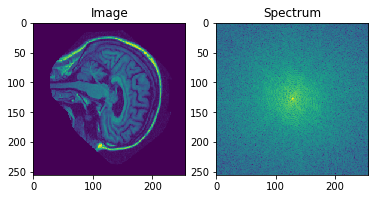

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(training[0])
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(np.log10(np.abs(Training[0])))
plt.title('Spectrum')
plt.show()

In [6]:
print('Extracting statistics and computing bands...', end='', flush=True)
m2v, v2m = conf.vect_functions()

shape = training[0].shape
n = np.prod(shape)

mag, mag_std, phs, phs_std = common.retrive_basic_stats(Training)

# direct sorting
sort = np.arange(n)
if conf.training['sort'] == 'random':
    sort = np.random.choice(n, size=n, replace=False)
elif conf.training['sort'] == 'energy':
    sort = m2v(mag).argsort()[::-1]
# inverse sorting
tros = common.inv(sort)

"""
Generate bands.
"""
energy = common.norm(m2v(mag_std)[sort])
comulated = common.norm(common.comulate(energy))
bands = lsc.divide(comulated, n_bands)
print(' [done]')

Extracting statistics and computing bands... [done]


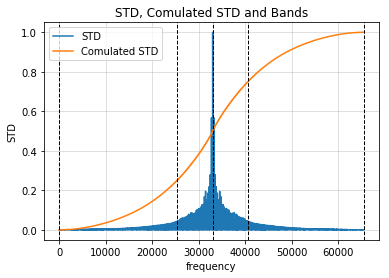

In [7]:
plt.plot(energy, label='STD')
plt.plot(comulated, label='Comulated STD')
plt.axvline(0, ls='--', lw=1, c='k')
for b in bands:
    plt.axvline(b, ls='--', lw=1, c='k')
plt.xlabel('frequency')
plt.ylabel('STD')
plt.grid(alpha=0.5)
plt.legend()
plt.title('STD, Comulated STD and Bands')
plt.show()

In [8]:
"""
Check if codebook is cached.
"""
codebook_path = f'codebooks/{conf.codebook_name()}'
if os.path.isfile(codebook_path):
    print('Loading existing codebooks...' ,end='', flush=True)
    with open(codebook_path, 'rb') as f:
        codebooks = pickle.load(f)
else:
    print('Computing codebooks...' ,end='', flush=True)
    """
    Prepare dataset for codes generation.
    """
    n_levels = conf.training['n_levels']
    n_codes = conf.training['n_codes']
    batch_size = conf.training['batch']

    normalize = m2v(mag)[sort]
    discretize = normalize/n_levels

    FlatTrn = m2v(Training)[:, sort]
    DiscTrn = np.round(FlatTrn/discretize) * discretize
    SBsTrn = lsc.split(DiscTrn, bands)

    """
    Compute codebook for each sub-band.
    """

    codebooks = lsc.gen_codebooks(SBsTrn, n_codes, mode='ReIm', 
                                     batch_size=batch_size)
    with open(codebook_path, 'wb') as f:
        pickle.dump(codebooks, f)
print(' [done]')
training = (sort, tros), (energy, comulated, bands), codebooks

Computing codebooks... [done]


If a codebook with exact same configuration has already been generated it will be loaded otherwise a new one will be generated.

## Testing

The testing is performed similarly:

In [9]:
# Load testing set
testing, Testing = common.load_dataset(conf.testingset_path(),
                                       conf.fformat, conf.size())
FlatTst = m2v(Testing)[:, sort]

In [10]:
# f_avg sampling pattern
Omega = energy.argsort()[::-1]

# lsc sampling pattern per band
Omegas = [c.sampling_pattern() for c in codebooks]

shape = testing[0].shape
n = np.prod(shape)
N = len(testing)


### Sampling Rate vs Reconstruction Quality

The following code is what the function `flow.test_sampling` implements. The code will show the average reconstruction error of the testing set at different sampling rate using different reconstruction frameworks: $k$-best, $f_{avg}$ and LSC. 

In [42]:
subcfg = conf.testing['reconstruction']


# sampling rate range    
srange = np.logspace(*subcfg['sampling_range'])

# results accumulator
bk_mse = np.zeros(len(srange))
fa_mse = np.zeros(len(srange))
rc_mse = np.zeros(len(srange))

bk_ssim = np.zeros(len(srange))
fa_ssim = np.zeros(len(srange))
rc_ssim = np.zeros(len(srange))


print('Sampling Rate vs Reconstruction Quality Test:')
for i, rate in enumerate(srange):
    print(f'\r {i+1:3d}/{len(srange)}', flush=True, end='')
    M = int(round(n*rate))
    m = int(round(M/n_bands))
    ms = lsc.num_samples(bands, m)
    M = np.sum(ms)

    smalls = [omega[:y] for omega, y in zip(Omegas, ms)]

    for idx in range(N):
        reference = common.norm(testing[idx])
        X = FlatTst[idx]

        Xsbs = lsc.split(X, bands)
        Ysbs = lsc.sub_sample(Xsbs, Omegas, m)
        recovered = [codebooks[b].reconstruct(Ysbs[b], smalls[b]) for b in range(len(bands))]
        Y = v2m((lsc.union(recovered))[tros], shape)
        y = common.norm(common.pos(common.ifft2(Y).real))


        BK = X.copy()[tros]
        # BK sampling pattern
        O = np.abs(BK).argsort()[::-1]
        BK[O[M:]] = 0
        BK = v2m(BK, shape)
        bK = common.norm(common.pos(common.ifft2(BK).real))    

        FA = X.copy()[tros]
        FA[Omega[M:]] = 0
        FA = v2m(FA, shape)
        fA = common.norm(common.pos(common.ifft2(FA).real))

        fa_mse[i] += mse(reference, fA) / N
        bk_mse[i] += mse(reference, bK) / N
        rc_mse[i] += mse(reference, y) / N

        fa_ssim[i] += ssim(reference, fA, gaussian_weights=True) / N
        bk_ssim[i] += ssim(reference, bK, gaussian_weights=True) / N
        rc_ssim[i] += ssim(reference, y, gaussian_weights=True) / N
print('\t[done]')

Sampling Rate vs Reconstruction Quality Test:
   8/8	[done]


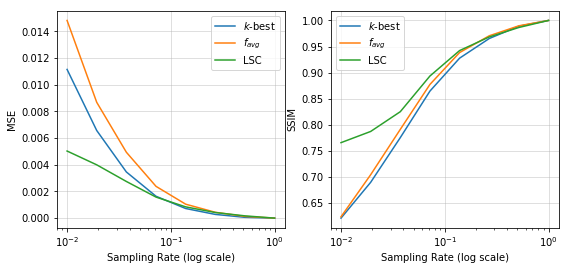

In [45]:
plt.figure(figsize=(9,4))

plt.subplot(1, 2, 1)
plt.semilogx(srange, bk_mse, label='$k$-best')
plt.semilogx(srange, fa_mse, label='$f_{avg}$')
plt.semilogx(srange, rc_mse, label='LSC')
plt.xlabel('Sampling Rate (log scale)')
plt.ylabel('MSE')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogx(srange, bk_ssim, label='$k$-best')
plt.semilogx(srange, fa_ssim, label='$f_{avg}$')
plt.semilogx(srange, rc_ssim, label='LSC')
plt.xlabel('Sampling Rate (log scale)')
plt.ylabel('SSIM')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

### Sampling Rate vs Reconstruction Visual Quality

The following code is what the function `flow.test_sampling_visual` implements. The code will show  reconstructions of a testing image at different sampling rate using different reconstruction frameworks: $k$-best, $f_{avg}$ and LSC.

In [56]:
subcfg = conf.testing['reconstruction_visual']
idx = 12
srange = np.logspace(*subcfg['sampling_range'])

X = FlatTst[idx].copy()
    
W, H = shape
Wt = W * 3
Ht = H * len(srange)

res = np.zeros((Wt, Ht))

print(f'Sampling Rate vs Reconstruction Quality Visual Test (img {idx}):')
for i, rate in enumerate(srange):
    print(f'\r {i+1:3d}/{len(srange)}', flush=True, end='')

    M = int(round(rate*n))       
    m = int(round(M/n_bands))
    ms = lsc.num_samples(bands, m)
    M = np.sum(ms)

    smalls = [omega[:y] for omega, y in zip(Omegas, ms)]

    Xsbs = lsc.split(X, bands)
    Ysbs = lsc.sub_sample(Xsbs, Omegas, m)

    recovered = [codebooks[b].reconstruct(Ysbs[b], smalls[b]) for b in range(len(bands))]
    Y = v2m((lsc.union(recovered))[tros], shape)
    y = common.norm(common.pos(common.ifft2(Y).real))


    BK = X.copy()[tros]
    O = np.abs(BK).argsort()[::-1]
    BK[O[M:]] = 0
    BK = v2m(BK, shape)
    bK = common.norm(common.pos(common.ifft2(BK).real))    

    FA = X.copy()[tros]
    FA[Omega[M:]] = 0
    FA = v2m(FA, shape)
    fA = common.norm(common.pos(common.ifft2(FA).real))

    res[:W, H*i:H*(i+1)] = bK
    res[W:2*W, H*i:H*(i+1)] = fA
    res[2*W:3*W, H*i:H*(i+1)] = y
print('\t[done]')

Sampling Rate vs Reconstruction Quality Visual Test (img 12):
   8/8	[done]


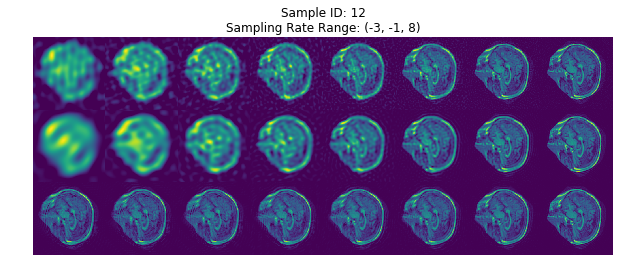

In [58]:
plt.figure(figsize=(24,4))
plt.title(f'Sample ID: {idx}\nSampling Rate Range: {subcfg["sampling_range"]}')
plt.imshow(res)
plt.axis('off')
plt.show()

## Robust Signal Processing

This section of tests will be focused on the system capability to recover noisy signals.

### Noise STD vs Reconstruction Quality Test

The following code is what the function `flow.test_robust` implements. The code will show  avarage reconstruction error and Signal Error Rate (SER) of the testing set at different noise STD using and fixed noise STD using different reconstruction frameworks: $k$-best, $f_{avg}$ and LSC.

The SER index between two images is computed as follow:
$$
\text{SER}(\vec{x}, \hat{x}) = 10 \log \frac{\sum_{i=0}^n\vec{x}_i^2}{\sum_{i=0}^n(\vec{x}-\hat{x})^2}
$$
where $\vec{x}$ is original signal and $\hat{x}$ is its extimation. Higher values of SER is better. 

In [68]:
subcfg = conf.testing['robust_reconstruction']
srange = np.logspace(*subcfg['noise_range'])
sampling_rate = subcfg['sampling_rate']    


bk_ser = np.zeros(len(srange))
fa_ser = np.zeros(len(srange))
rc_ser = np.zeros(len(srange))

bk_mse = np.zeros(len(srange))
fa_mse = np.zeros(len(srange))
rc_mse = np.zeros(len(srange))

print('Robust recovering test:')
for i, sigma in enumerate(srange):
    print(f'\r {i+1:3d}/{len(srange)}', end='', flush=True)
    M = int(round(n*sampling_rate))
    m = int(round(M/n_bands))
    ms = lsc.num_samples(bands, m)
    M = np.sum(ms)

    smalls = [omega[:y] for omega, y in zip(Omegas, ms)]

    for idx in range(N):
        reference = common.norm(testing[idx])
        X = FlatTst[idx] + common.noise(sigma, n)

        Xsbs = lsc.split(X, bands)
        Ysbs = lsc.sub_sample(Xsbs, Omegas, m)
        recovered = [codebooks[b].reconstruct(Ysbs[b], smalls[b]) for b in range(len(bands))]
        Y = v2m((lsc.union(recovered))[tros], shape)
        y = common.norm(common.pos(common.ifft2(Y).real))           

        BK = X.copy()[tros]
        O = np.abs(BK).argsort()[::-1]
        BK[O[M:]] = 0
        BK = v2m(BK, shape)
        bK = common.norm(common.pos(common.ifft2(BK).real))    

        FA = X.copy()[tros]
        FA[Omega[M:]] = 0
        FA = v2m(FA, shape)
        fA = common.norm(common.pos(common.ifft2(FA).real))

        fa_ser[i] += common.SER(reference, fA) / N
        bk_ser[i] += common.SER(reference, bK) / N
        rc_ser[i] += common.SER(reference, y) / N

        fa_mse[i] += mse(reference, fA) / N
        bk_mse[i] += mse(reference, bK) / N
        rc_mse[i] += mse(reference, y) / N
print(' [done]')

Robust recovering test:
   8/8 [done]


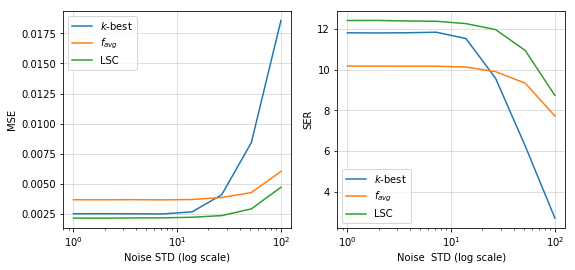

In [69]:
plt.figure(figsize=(9,4))
plt.subplot(1, 2, 1)
plt.semilogx(srange, bk_mse, label='$k$-best')
plt.semilogx(srange, fa_mse, label='$f_{avg}$')
plt.semilogx(srange, rc_mse, label='LSC')
plt.xlabel('Noise STD (log scale)')
plt.ylabel('MSE')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogx(srange, bk_ser, label='$k$-best')
plt.semilogx(srange, fa_ser, label='$f_{avg}$')
plt.semilogx(srange, rc_ser, label='LSC')
plt.xlabel('Noise  STD (log scale)')
plt.ylabel('SER')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

### Noise STD vs Reconstruction Quality Visual Test

The following code is what the function `flow.test_robust_visual` implements. The code will show   reconstruction of a testing image at different noise STD using and fixed sampling rate using different reconstruction frameworks: $k$-best, $f_{avg}$ and LSC.

In [60]:
subcfg = conf.testing['robust_reconstruction_visual']
srange = np.logspace(*subcfg['noise_range'])
sampling_rate = subcfg['sampling_rate']

idx = 12 

W, H = shape
Wt = W * 3
Ht = H * len(srange)

res = np.zeros((Wt, Ht))

print(f'Robust Reconstruction Quality Visual Test (img {idx}):')
for i, sigma in enumerate(srange):
    print(f'\r {i+1:3d}/{len(srange)}', flush=True, end='')
    X = FlatTst[idx] + common.noise(sigma, n)

    M = int(round(sampling_rate*n))       
    m = int(round(M/n_bands))
    ms = lsc.num_samples(bands, m)
    M = np.sum(ms)

    smalls = [omega[:y] for omega, y in zip(Omegas, ms)]

    Xsbs = lsc.split(X, bands)
    Ysbs = lsc.sub_sample(Xsbs, Omegas, m)

    recovered = [codebooks[b].reconstruct(Ysbs[b], smalls[b]) for b in range(len(bands))]
    Y = v2m((lsc.union(recovered))[tros], shape)
    y = common.norm(common.pos(common.ifft2(Y).real))


    BK = X.copy()[tros]
    O = np.abs(BK).argsort()[::-1]
    BK[O[M:]] = 0
    BK = v2m(BK, shape)
    bK = common.norm(common.pos(common.ifft2(BK).real))    

    FA = X.copy()[tros]
    FA[Omega[M:]] = 0
    FA = v2m(FA, shape)
    fA = common.norm(common.pos(common.ifft2(FA).real))

    res[:W, H*i:H*(i+1)] = bK
    res[W:2*W, H*i:H*(i+1)] = fA
    res[2*W:3*W, H*i:H*(i+1)] = y
print('\t[done]')

Robust Reconstruction Quality Visual Test (img 12):
   8/8	[done]


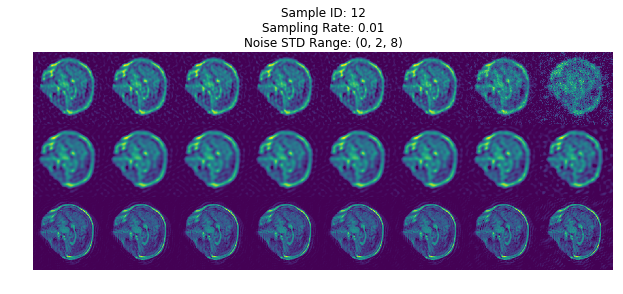

In [61]:
plt.figure(figsize=(24,4))
plt.title(f'Sample ID: {idx}\nSampling Rate: {sampling_rate}\nNoise STD Range: {subcfg["noise_range"]}')
plt.imshow(res)
plt.axis('off')
plt.show()

### Sampling Rate vs Reconstruction Robust Reconstruction QualityTest

The following code is what the function `flow.test_robust_sampling` implements. The code will show  average MSE and SER of the testing dataset at different sampling rate and fixed noise STD using different reconstruction frameworks: $k$-best, $f_{avg}$ and LSC.

In [66]:
subcfg = conf.testing['robust_sampling']
srange = np.logspace(*subcfg['sampling_range'])
sigma = subcfg['noise_rate']

bk_ser = np.zeros(len(srange))
fa_ser = np.zeros(len(srange))
rc_ser = np.zeros(len(srange))

bk_mse = np.zeros(len(srange))
fa_mse = np.zeros(len(srange))
rc_mse = np.zeros(len(srange))
print('Sampling rate at fixed noise test:')
for i, rate in enumerate(srange):
    print(f'\r {i+1:3d}/{len(srange)}', flush=True, end='')
    M = int(round(n*rate))
    m = int(round(M/n_bands))
    ms = lsc.num_samples(bands, m)
    M = np.sum(ms)
    smalls = [omega[:y] for omega, y in zip(Omegas, ms)]

    for idx in range(N):
        reference = common.norm(testing[idx])
        X = FlatTst[idx] + common.noise(sigma, n)

        Xsbs = lsc.split(X, bands)
        Ysbs = lsc.sub_sample(Xsbs, Omegas, m)
        recovered = [codebooks[b].reconstruct(Ysbs[b], smalls[b]) for b in range(len(bands))]
        Y = v2m((lsc.union(recovered))[tros], shape)
        y = common.norm(common.pos(common.ifft2(Y).real))


        BK = X.copy()[tros]
        O = np.abs(BK).argsort()[::-1]
        BK[O[M:]] = 0
        BK = v2m(BK, shape)
        bK = common.norm(common.pos(common.ifft2(BK).real))    

        FA = X.copy()[tros]
        FA[Omega[M:]] = 0
        FA = v2m(FA, shape)
        fA = common.norm(common.pos(common.ifft2(FA).real))

        fa_ser[i] += common.SER(reference, fA) / N
        bk_ser[i] += common.SER(reference, bK) / N
        rc_ser[i] += common.SER(reference, y) / N

        fa_mse[i] += mse(reference, fA) / N
        bk_mse[i] += mse(reference, bK) / N
        rc_mse[i] += mse(reference, y) / N
print(' [done]')

Sampling rate at fixed noise test:
   8/8 [done]


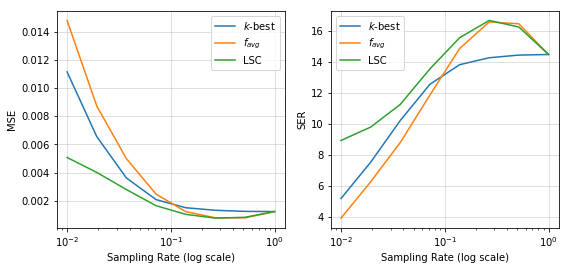

In [67]:
plt.figure(figsize=(9,4))
plt.subplot(1, 2, 1)
plt.semilogx(srange, bk_mse, label='$k$-best')
plt.semilogx(srange, fa_mse, label='$f_{avg}$')
plt.semilogx(srange, rc_mse, label='LSC')
plt.xlabel('Sampling Rate (log scale)')
plt.ylabel('MSE')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogx(srange, bk_ser, label='$k$-best')
plt.semilogx(srange, fa_ser, label='$f_{avg}$')
plt.semilogx(srange, rc_ser, label='LSC')
plt.xlabel('Sampling Rate (log scale)')
plt.ylabel('SER')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

Other experiments can be easily performed using the `lsc.py` library, such as code identification precision, different sorting and vectorisation policy and more.
